In [39]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
import acd
from copy import deepcopy
from model_fashion_mnist import Net, Net2c, FashionCNN
from visualize import *
import dset_fashion_mnist as dset
import foolbox
sys.path.append('../trim')
from transforms_torch import transform_bandpass, tensor_t_augment, batch_fftshift2d, batch_ifftshift2d
from trim import *
from util import *
from attributions import *
from captum.attr import *
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# set args
args = dset.get_args()
args.cuda = "True"
args.test_batch_size = 100

# load fashion-mnist dataset
train_loader, test_loader = dset.load_data(args.batch_size, args.test_batch_size, device)

# model
model = FashionCNN().to(device)
model.load_state_dict(torch.load('./fashion-mnist.model.pth', map_location=device))
model = model.eval().to(device)
dset.test(model, test_loader, args)


Test set: Average loss: -47.7807, Accuracy: 9032/10000 (90.32%)



In [3]:
# foolbox model
preprocessing = dict(mean=[0,], std=[1,], axis=-3)
fmodel = foolbox.models.PyTorchModel(model, bounds=(0, 1), num_classes=10, preprocessing=preprocessing)

# get a batch of images and labels and print the accuracy
images, labels = iter(test_loader).next()
images = images.numpy()
labels = labels.numpy()
print(np.mean(fmodel.forward(images).argmax(axis=-1) == labels))

# apply the attack
attack = foolbox.attacks.FGSM(fmodel)
im_adversarials = attack(images, labels)
# if the i'th image is misclassfied without a perturbation, then adversarials[i] will be the same as images[i]
# if the attack fails to find an adversarial for the i'th image, then adversarials[i] will all be np.nan
# Foolbox guarantees that all returned adversarials are in fact in adversarials
print(np.mean(fmodel.forward(im_adversarials).argmax(axis=-1) == labels))

# # You can always get the actual adversarial class that was observed for that sample by Foolbox by
# # passing `unpack=False` to get the actual `Adversarial` objects:
attack = foolbox.attacks.FGSM(fmodel, distance=foolbox.distances.Linf)
adversarials = attack(images, labels, unpack=False)

adversarial_classes = np.asarray([a.adversarial_class for a in adversarials])
# print(labels)
# print(adversarial_classes)
# print(np.mean(adversarial_classes == labels))  # will always be 0.0

# The `Adversarial` objects also provide a `distance` attribute. Note that the distances
# can be 0 (misclassified without perturbation) and inf (attack failed).
distances = np.asarray([a.distance.value for a in adversarials])
print("{:.1e}, {:.1e}, {:.1e}".format(distances.min(), np.median(distances), distances.max()))
print("{} of {} attacks failed".format(sum(adv.distance.value == np.inf for adv in adversarials), len(adversarials)))
print("{} of {} inputs misclassified without perturbation".format(sum(adv.distance.value == 0 for adv in adversarials), len(adversarials)))

0.93
0.0
0.0e+00, 3.0e-02, inf
3 of 100 attacks failed
7 of 100 inputs misclassified without perturbation


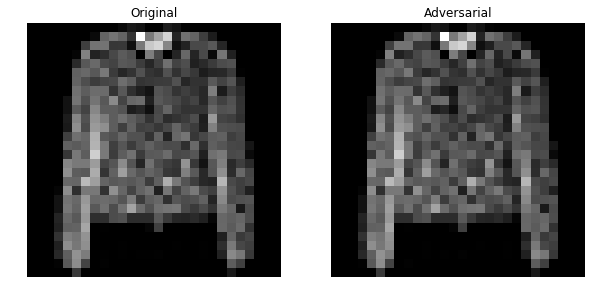

True and perturbed labels:  Coat Shirt


In [4]:
# index with minimum dist to orig. image while perturbation suceed
min_idx = np.where(distances == np.min(distances[np.nonzero(distances)]))[0][0]
im = images[min_idx]
im_a = im_adversarials[min_idx]
viz_im_a(im.squeeze(), im_a.squeeze())
print('True and perturbed labels: ', dset.output_label(labels[min_idx]), dset.output_label(adversarial_classes[min_idx]))

## Interpret adversarial images

In [5]:
# FFT
t = lambda x: torch.fft(torch.stack((x, torch.zeros_like(x)),dim=4), 2)
transform_i = modularize(lambda x: torch.ifft(x, 2)[...,0])

# prepend transformation
model = model.to(device)
model_t = TrimModel(model, transform_i)

# interp methods
attr_methods = ['IG', 'DeepLift', 'SHAP', 'InputXGradient']

# band center and width
band_centers = list(np.arange(1, 40) * 0.025)
band_width_lower = 0.025
band_width_upper = 0.025

# indexes
idx_adv = np.logical_and(distances > 0, distances < np.inf)
idx_fail = distances == np.inf


#### images that succeed adversarial attack

In [6]:
im_scores = {
    'IG': [],
    'DeepLift': [],
    'SHAP': [],
#     'CD': [], no support on batch with different class labels
    'InputXGradient': []
}
im = torch.from_numpy(images[idx_adv]).to(device)
im_t = t(im)
target = torch.from_numpy(labels[idx_adv]).to(device)
scores = {
    'IG': [],
    'DeepLift': [],
    'SHAP': [],
    'InputXGradient': []
}  
# attr
results = get_attributions(im_t, model_t, class_num=target, attr_methods=attr_methods, device=device)

for band_center in band_centers:
    mask = ifftshift(freq_band(28, band_center, band_width_lower, band_width_upper))
    for name in attr_methods:
        im_attr = (results[name] * mask).sum(axis=(1,2))
        scores[name].append(im_attr)
im_scores['IG'] = np.array(scores['IG'])
im_scores['DeepLift'] = np.array(scores['DeepLift'])
im_scores['SHAP'] = np.array(scores['SHAP'])
im_scores['InputXGradient'] = np.array(scores['InputXGradient'])        

#### adversarial images 

In [11]:
im_a_scores = {
    'IG': [],
    'DeepLift': [],
    'SHAP': [],
#     'CD': [], no support on batch with different class labels
    'InputXGradient': []
}
im = torch.from_numpy(im_adversarials[idx_adv]).to(device)
im_t = t(im)
adv_labels = np.array(adversarial_classes[idx_adv], dtype=np.int)
target = torch.from_numpy(adv_labels).to(device)
scores = {
    'IG': [],
    'DeepLift': [],
    'SHAP': [],
    'InputXGradient': []
}  
# attr
results = get_attributions(im_t, model_t, class_num=target, attr_methods=attr_methods, device=device)

for band_center in band_centers:
    mask = ifftshift(freq_band(28, band_center, band_width_lower, band_width_upper))
    for name in attr_methods:
        im_attr = (results[name] * mask).sum(axis=(1,2))
        scores[name].append(im_attr)
im_a_scores['IG'] = np.array(scores['IG'])
im_a_scores['DeepLift'] = np.array(scores['DeepLift'])
im_a_scores['SHAP'] = np.array(scores['SHAP'])
im_a_scores['InputXGradient'] = np.array(scores['InputXGradient'])        

#### images that fail adversarial attack

In [12]:
im_f_scores = {
    'IG': [],
    'DeepLift': [],
    'SHAP': [],
#     'CD': [], no support on batch with different class labels
    'InputXGradient': []
}
im = torch.from_numpy(images[idx_fail]).to(device)
im_t = t(im)
target = torch.from_numpy(labels[idx_fail]).to(device)
scores = {
    'IG': [],
    'DeepLift': [],
    'SHAP': [],
    'InputXGradient': []
}  
# attr
results = get_attributions(im_t, model_t, class_num=target, attr_methods=attr_methods, device=device)

for band_center in band_centers:
    mask = ifftshift(freq_band(28, band_center, band_width_lower, band_width_upper))
    for name in attr_methods:
        im_attr = (results[name] * mask).sum(axis=(1,2))
        scores[name].append(im_attr)
im_f_scores['IG'] = np.array(scores['IG'])
im_f_scores['DeepLift'] = np.array(scores['DeepLift'])
im_f_scores['SHAP'] = np.array(scores['SHAP'])
im_f_scores['InputXGradient'] = np.array(scores['InputXGradient'])        

#### plot

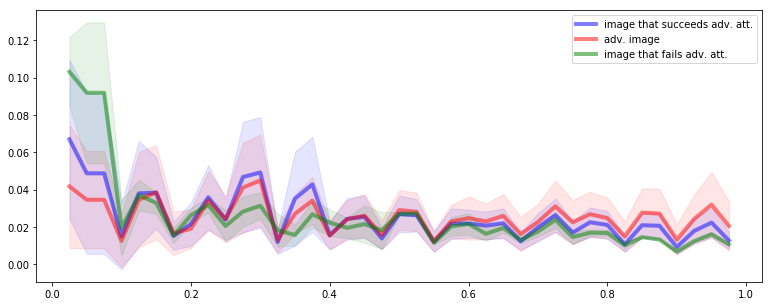

In [38]:
band_idx = 0
fig, ax = plt.subplots(1, 1, figsize=(13,5))
im_avg = im_scores['IG'].mean(axis=1)/im_scores['IG'].mean(axis=1).sum()
im_sd = im_scores['IG'].std(axis=1)/im_scores['IG'].mean(axis=1).sum()
im_a_avg = im_a_scores['IG'].mean(axis=1)/im_a_scores['IG'].mean(axis=1).sum()
im_a_sd = im_a_scores['IG'].std(axis=1)/im_a_scores['IG'].mean(axis=1).sum()
im_f_avg = im_f_scores['IG'].mean(axis=1)/im_f_scores['IG'].mean(axis=1).sum()
im_f_sd = im_f_scores['IG'].std(axis=1)/im_f_scores['IG'].mean(axis=1).sum()
ax.plot(band_centers, im_avg, alpha=0.5, color='blue', label='image that succeeds adv. att.', linewidth=4.0)
ax.fill_between(band_centers, im_avg - im_sd, 
                    im_avg + im_sd, color='blue', alpha=0.1)
ax.plot(band_centers, im_a_avg, alpha=0.5, color='red', label='adv. image', linewidth=4.0)
ax.fill_between(band_centers, im_a_avg - im_a_sd, 
                    im_a_avg + im_a_sd, color='red', alpha=0.1)
ax.plot(band_centers, im_f_avg, alpha=0.5, color='green', label='image that fails adv. att.', linewidth=4.0)
ax.fill_between(band_centers, im_f_avg - im_f_sd, 
                    im_f_avg + im_f_sd, color='green', alpha=0.1)
ax.legend()
plt.show()

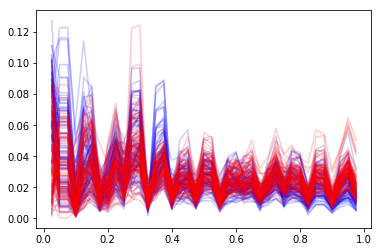

In [55]:
plt.plot(band_centers, im_scores['IG']/im_scores['IG'].sum(axis=0), 
         alpha=0.2, color='blue', label='image that succeeds adv. att.')
plt.plot(band_centers, im_a_scores['IG']/im_a_scores['IG'].sum(axis=0), 
         alpha=0.2, color='red', label='adv. image')
plt.show()